In [1]:
# !pip3 install tune-sklearn "ray[tune]"
# !pip3 install cloudpickle imbalanced-learn scikit-optimize

In [27]:
import sys
import os
import math

from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import r2_score, roc_auc_score, classification_report
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.svm import SVC
#import seaborn as sns
import time

sys.path.append('/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction')
sys.path.append("/Users/agaut/Documents/Stanford -- Graduate School/first-year/fall/cs329p/project/Multimodal-deep-learning-for-poverty-prediction")
from utils.get_data_loader import SustainBenchTextDataset
from utils.file_utils import *

In [28]:
CLASSIFICATION_THRESHOLD_DICT = {'asset_index': 0, 'sanitation_index': 3, 'water_index': 3, 'women_edu': 5}
TARGETS = ['asset_index', 'sanitation_index', 'water_index', 'women_edu']
FEATURES = [['target_sentence'], ['all_sentence'], ['document'], ['target_sentence', 'all_sentence'], ['target_sentence', 'document'], ['all_sentence', 'document'], ['target_sentence', 'all_sentence', 'document']]

### Regression: ridge regression, random forest regressor

In [29]:
def regression(X_train, y_train, X_test, y_test):   
    base_estimator = KernelRidge(kernel='rbf')
    param_grid = {'kernel': ['linear', 'rbf'], 'alpha': np.logspace(-2,3,50)}
    sklearn_search = HalvingGridSearchCV(
        base_estimator, 
        param_grid, 
        cv=3,
        factor=2,
        resource='n_samples',
        error_score=-np.inf
    )

    start = time.time()
    sklearn_search.fit(X_train, y_train)
    end = time.time()
    y_pred = sklearn_search.predict(X_test)

    score = r2_score(y_test, y_pred)
    print(f'sklearn HalvingGridSearchCV fit time: {round(end - start, 3)}s, r^2: {round(score, 3)}')
    print(f'best estimator: {sklearn_search.best_estimator_}\n')
    
    return score

In [30]:
scores = np.zeros((len(TARGETS), len(FEATURES)))
for i, target in enumerate(TARGETS):
    for j, features in enumerate(FEATURES):
        ds = SustainBenchTextDataset(
            data_dir=f'/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/data/', 
            features=features, 
            target=target,
            model_type='regression',
            classification_threshold=CLASSIFICATION_THRESHOLD_DICT[target]
        )

        print(target, features)
        X_train, y_train = ds.get_data('train')
        X_test, y_test = ds.get_data('test')
        print(f'train data shape: {X_train.shape}, test data shape: {X_test.shape}')
        
        scores[i,j] = regression(X_train, y_train, X_test, y_test)
    print()

asset_index ['target_sentence']


FileNotFoundError: [Errno 2] File /Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/data/sentence_embeddings/AL/asset_index/metadata.csv does not exist: '/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/data/sentence_embeddings/AL/asset_index/metadata.csv'

<AxesSubplot:>

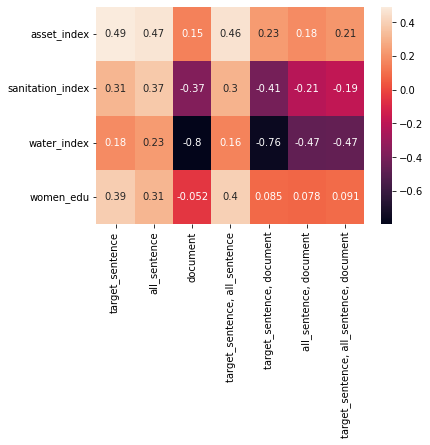

In [6]:
sns.heatmap(scores, annot=True, xticklabels=[", ".join(features) for features in FEATURES], yticklabels=TARGETS)

### Classification: SVM, logistic regression, random forest classifier

In [7]:
def classification(X_train, y_train, X_test, y_test):
    base_estimator = Pipeline(steps=[("scaler", MaxAbsScaler()), ("lr", LogisticRegression(max_iter=500))])
    param_grid = {'lr__C': np.logspace(-1,2,20)}
    sklearn_search = HalvingGridSearchCV(
        base_estimator, 
        param_grid, 
        cv=3,
        factor=2,
        max_resources=100,
        error_score=0
    )

    start = time.time()
    sklearn_search.fit(X_train, y_train)
    end = time.time()
    y_pred = sklearn_search.predict(X_test)

    score = roc_auc_score(y_test, y_pred)
    print(f'sklearn HalvingGridSearchCV fit time: {round(end - start, 3)}s, roc auc: {round(score, 3)}')
    print(f'best estimator: {sklearn_search.best_estimator_}')
    print(classification_report(y_test, y_pred))
    print()
    
    return score

In [8]:
scores = np.zeros((len(TARGETS), len(FEATURES)))
for i, target in enumerate(TARGETS):
    for j, features in enumerate(FEATURES):
        ds = SustainBenchTextDataset(
            data_dir=f'/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/data/', 
            features=features, 
            target=target,
            model_type='classification',
            classification_threshold=CLASSIFICATION_THRESHOLD_DICT[target]
        )

        print(target, features)
        X_train, y_train = ds.get_data('train')
        X_test, y_test = ds.get_data('test')
        print(f'train data shape: {X_train.shape}, test data shape: {X_test.shape}')
        print(f'{sum(y_train)} ({np.round(sum(y_train)/X_train.shape[0] * 100, 2)}%) positive examples in train data, {sum(y_test)} ({np.round(sum(y_test)/X_test.shape[0] * 100, 2)}%) positive examples in test data\n')
        scores[i,j] = classification(X_train, y_train, X_test, y_test) 
        print()

asset_index ['target_sentence']
train data shape: (2028, 384), test data shape: (390, 384)
502 (24.75%) positive examples in train data, 122 (31.28%) positive examples in test data

sklearn HalvingGridSearchCV fit time: 0.517s, roc auc: 0.808
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr',
                 LogisticRegression(C=0.14384498882876628, max_iter=500))])
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       268
           1       0.78      0.70      0.74       122

    accuracy                           0.85       390
   macro avg       0.83      0.81      0.82       390
weighted avg       0.84      0.85      0.84       390



asset_index ['all_sentence']
The PCA model explains 45.847% of the variance in the embedding data
train data shape: (5823, 384), test data shape: (1025, 384)
1553 (26.67%) positive examples in train data, 422 (41.17%) positive examples in test data

sklearn HalvingGrid

/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/pipeline.p

sklearn HalvingGridSearchCV fit time: 0.646s, roc auc: 0.755
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr',
                 LogisticRegression(C=0.14384498882876628, max_iter=500))])
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       603
           1       0.74      0.68      0.71       422

    accuracy                           0.77      1025
   macro avg       0.76      0.75      0.76      1025
weighted avg       0.77      0.77      0.77      1025



asset_index ['target_sentence', 'all_sentence', 'document']
The PCA model explains 45.848% of the variance in the embedding data
train data shape: (2028, 1068), test data shape: (390, 1068)
502 (24.75%) positive examples in train data, 122 (31.28%) positive examples in test data



/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/pipeline.p

sklearn HalvingGridSearchCV fit time: 1.221s, roc auc: 0.604
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr', LogisticRegression(C=69.51927961775606, max_iter=500))])
              precision    recall  f1-score   support

           0       0.77      0.63      0.69       268
           1       0.42      0.58      0.48       122

    accuracy                           0.61       390
   macro avg       0.59      0.60      0.59       390
weighted avg       0.66      0.61      0.63       390



sanitation_index ['target_sentence']
train data shape: (2660, 384), test data shape: (579, 384)
832 (31.28%) positive examples in train data, 286 (49.4%) positive examples in test data

sklearn HalvingGridSearchCV fit time: 0.579s, roc auc: 0.696
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr',
                 LogisticRegression(C=0.29763514416313175, max_iter=500))])
              precision    recall  f1-score   support

         

/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/pipeline.p

sklearn HalvingGridSearchCV fit time: 0.388s, roc auc: 0.73
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr',
                 LogisticRegression(C=0.29763514416313175, max_iter=500))])
              precision    recall  f1-score   support

           0       0.72      0.89      0.80       632
           1       0.80      0.57      0.67       508

    accuracy                           0.75      1140
   macro avg       0.76      0.73      0.73      1140
weighted avg       0.76      0.75      0.74      1140



sanitation_index ['document']
train data shape: (9451, 300), test data shape: (1923, 300)
3263 (34.53%) positive examples in train data, 792 (41.19%) positive examples in test data

sklearn HalvingGridSearchCV fit time: 0.571s, roc auc: 0.585
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr', LogisticRegression(C=5.455594781168517, max_iter=500))])
              precision    recall  f1-score   support

           0  

/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/pipeline.p

sklearn HalvingGridSearchCV fit time: 0.654s, roc auc: 0.603
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr',
                 LogisticRegression(C=0.20691380811147897, max_iter=500))])
              precision    recall  f1-score   support

           0       0.58      0.85      0.69       293
           1       0.70      0.36      0.47       286

    accuracy                           0.61       579
   macro avg       0.64      0.60      0.58       579
weighted avg       0.64      0.61      0.58       579



sanitation_index ['target_sentence', 'document']
train data shape: (2660, 684), test data shape: (579, 684)
832 (31.28%) positive examples in train data, 286 (49.4%) positive examples in test data

sklearn HalvingGridSearchCV fit time: 0.872s, roc auc: 0.672
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr', LogisticRegression(C=1.2742749857031335, max_iter=500))])
              precision    recall  f1-score   suppo

/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/pipeline.p

sklearn HalvingGridSearchCV fit time: 0.38s, roc auc: 0.53
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr',
                 LogisticRegression(C=0.14384498882876628, max_iter=500))])
              precision    recall  f1-score   support

           0       0.76      0.95      0.85       769
           1       0.44      0.11      0.17       256

    accuracy                           0.74      1025
   macro avg       0.60      0.53      0.51      1025
weighted avg       0.68      0.74      0.68      1025



water_index ['document']
train data shape: (9721, 300), test data shape: (1742, 300)
1036 (10.66%) positive examples in train data, 392 (22.5%) positive examples in test data



/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/pipeline.p

sklearn HalvingGridSearchCV fit time: 0.463s, roc auc: 0.514
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr',
                 LogisticRegression(C=0.29763514416313175, max_iter=500))])
              precision    recall  f1-score   support

           0       0.78      0.97      0.86      1350
           1       0.36      0.06      0.10       392

    accuracy                           0.76      1742
   macro avg       0.57      0.51      0.48      1742
weighted avg       0.69      0.76      0.69      1742



water_index ['target_sentence', 'all_sentence']
The PCA model explains 45.849% of the variance in the embedding data
train data shape: (3232, 768), test data shape: (614, 768)
351 (10.86%) positive examples in train data, 163 (26.55%) positive examples in test data



/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/pipeline.p

sklearn HalvingGridSearchCV fit time: 0.504s, roc auc: 0.511
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr',
                 LogisticRegression(C=0.14384498882876628, max_iter=500))])
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       451
           1       0.32      0.10      0.15       163

    accuracy                           0.71       614
   macro avg       0.53      0.51      0.49       614
weighted avg       0.63      0.71      0.64       614



water_index ['target_sentence', 'document']
train data shape: (3232, 684), test data shape: (614, 684)
351 (10.86%) positive examples in train data, 163 (26.55%) positive examples in test data

sklearn HalvingGridSearchCV fit time: 0.683s, roc auc: 0.556
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr',
                 LogisticRegression(C=0.20691380811147897, max_iter=500))])
              precision    recall  f1

/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/pipeline.p

sklearn HalvingGridSearchCV fit time: 0.508s, roc auc: 0.579
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr',
                 LogisticRegression(C=0.14384498882876628, max_iter=500))])
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       769
           1       0.48      0.25      0.33       256

    accuracy                           0.75      1025
   macro avg       0.63      0.58      0.58      1025
weighted avg       0.71      0.75      0.71      1025



water_index ['target_sentence', 'all_sentence', 'document']
The PCA model explains 45.845% of the variance in the embedding data
train data shape: (3232, 1068), test data shape: (614, 1068)
351 (10.86%) positive examples in train data, 163 (26.55%) positive examples in test data

sklearn HalvingGridSearchCV fit time: 0.833s, roc auc: 0.529
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr',
                 LogisticR

/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/pipeline.p

sklearn HalvingGridSearchCV fit time: 0.451s, roc auc: 0.586
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr',
                 LogisticRegression(C=0.14384498882876628, max_iter=500))])
              precision    recall  f1-score   support

           0       0.60      0.96      0.74       639
           1       0.81      0.21      0.34       523

    accuracy                           0.62      1162
   macro avg       0.70      0.59      0.54      1162
weighted avg       0.69      0.62      0.56      1162



women_edu ['all_sentence']
The PCA model explains 45.847% of the variance in the embedding data
train data shape: (7344, 384), test data shape: (1857, 384)
1695 (23.08%) positive examples in train data, 736 (39.63%) positive examples in test data



/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/pipeline.p

sklearn HalvingGridSearchCV fit time: 0.394s, roc auc: 0.539
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr', LogisticRegression(C=0.1, max_iter=500))])
              precision    recall  f1-score   support

           0       0.62      0.96      0.76      1121
           1       0.66      0.12      0.20       736

    accuracy                           0.63      1857
   macro avg       0.64      0.54      0.48      1857
weighted avg       0.64      0.63      0.54      1857



women_edu ['document']
train data shape: (12374, 300), test data shape: (3015, 300)
3498 (28.27%) positive examples in train data, 1038 (34.43%) positive examples in test data

sklearn HalvingGridSearchCV fit time: 0.661s, roc auc: 0.549
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr', LogisticRegression(C=0.8858667904100825, max_iter=500))])
              precision    recall  f1-score   support

           0       0.68      0.90      0.78      1

/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/pipeline.p

sklearn HalvingGridSearchCV fit time: 0.68s, roc auc: 0.536
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr',
                 LogisticRegression(C=0.29763514416313175, max_iter=500))])
              precision    recall  f1-score   support

           0       0.62      0.91      0.74      1121
           1       0.54      0.16      0.25       736

    accuracy                           0.61      1857
   macro avg       0.58      0.54      0.49      1857
weighted avg       0.59      0.61      0.55      1857



women_edu ['target_sentence', 'all_sentence', 'document']
The PCA model explains 45.849% of the variance in the embedding data
train data shape: (4571, 1068), test data shape: (1162, 1068)
920 (20.13%) positive examples in train data, 523 (45.01%) positive examples in test data

sklearn HalvingGridSearchCV fit time: 1.874s, roc auc: 0.543
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr', LogisticRegression(C=5.45559

<AxesSubplot:>

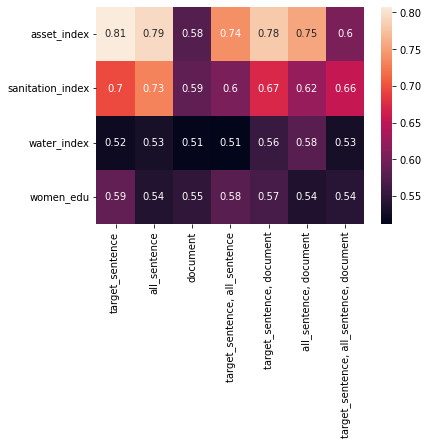

In [9]:
sns.heatmap(scores, annot=True, xticklabels=[", ".join(features) for features in FEATURES], yticklabels=TARGETS)

In [10]:
scores = np.zeros((len(TARGETS), len(FEATURES)))
for i, target in enumerate(TARGETS):
    for j, features in enumerate(FEATURES):
        ds = SustainBenchTextDataset(
            data_dir=f'/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/data/', 
            features=features, 
            target=target,
            model_type='classification',
            classification_threshold=CLASSIFICATION_THRESHOLD_DICT[target],
            rebalance=True
        )

        print(target, features)
        X_train, y_train = ds.get_data('train')
        X_test, y_test = ds.get_data('test')
        print(f'train data shape: {X_train.shape}, test data shape: {X_test.shape}')
        print(f'{sum(y_train)} ({np.round(sum(y_train)/X_train.shape[0] * 100, 2)}%) positive examples in train data, {sum(y_test)} ({np.round(sum(y_test)/X_test.shape[0] * 100, 2)}%) positive examples in test data\n')
        scores[i,j] = classification(X_train, y_train, X_test, y_test) 
        print()

asset_index ['target_sentence']
train data shape: (2156, 384), test data shape: (390, 384)
654 (30.33%) positive examples in train data, 122 (31.28%) positive examples in test data



/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/pipeline.p

sklearn HalvingGridSearchCV fit time: 0.38s, roc auc: 0.8
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr', LogisticRegression(C=0.1, max_iter=500))])
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       268
           1       0.71      0.74      0.72       122

    accuracy                           0.82       390
   macro avg       0.79      0.80      0.80       390
weighted avg       0.83      0.82      0.82       390



asset_index ['all_sentence']
The PCA model explains 45.845% of the variance in the embedding data
train data shape: (5960, 384), test data shape: (1025, 384)
1830 (30.7%) positive examples in train data, 422 (41.17%) positive examples in test data

sklearn HalvingGridSearchCV fit time: 0.405s, roc auc: 0.8
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr', LogisticRegression(C=0.1, max_iter=500))])
              precision    recall  f1-score   support

/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/pipeline.p

sklearn HalvingGridSearchCV fit time: 0.555s, roc auc: 0.774
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr',
                 LogisticRegression(C=0.14384498882876628, max_iter=500))])
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       268
           1       0.63      0.75      0.68       122

    accuracy                           0.78       390
   macro avg       0.75      0.77      0.76       390
weighted avg       0.80      0.78      0.79       390



asset_index ['target_sentence', 'document']
train data shape: (2179, 684), test data shape: (390, 684)
654 (30.01%) positive examples in train data, 122 (31.28%) positive examples in test data



/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


sklearn HalvingGridSearchCV fit time: 1.07s, roc auc: 0.6
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr', LogisticRegression(C=69.51927961775606, max_iter=500))])
              precision    recall  f1-score   support

           0       0.77      0.60      0.67       268
           1       0.41      0.60      0.48       122

    accuracy                           0.60       390
   macro avg       0.59      0.60      0.58       390
weighted avg       0.65      0.60      0.61       390



asset_index ['all_sentence', 'document']
The PCA model explains 45.848% of the variance in the embedding data
train data shape: (6090, 684), test data shape: (1025, 684)
1830 (30.05%) positive examples in train data, 422 (41.17%) positive examples in test data



/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/pipeline.p

sklearn HalvingGridSearchCV fit time: 0.587s, roc auc: 0.742
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr',
                 LogisticRegression(C=0.14384498882876628, max_iter=500))])
              precision    recall  f1-score   support

           0       0.78      0.81      0.80       603
           1       0.71      0.67      0.69       422

    accuracy                           0.75      1025
   macro avg       0.75      0.74      0.74      1025
weighted avg       0.75      0.75      0.75      1025



asset_index ['target_sentence', 'all_sentence', 'document']
The PCA model explains 45.847% of the variance in the embedding data
train data shape: (2178, 1068), test data shape: (390, 1068)
654 (30.03%) positive examples in train data, 122 (31.28%) positive examples in test data

sklearn HalvingGridSearchCV fit time: 0.932s, roc auc: 0.658
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr', LogisticRegression(C=1.274

/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/pipeline.p

sklearn HalvingGridSearchCV fit time: 0.525s, roc auc: 0.581
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr', LogisticRegression(C=1.2742749857031335, max_iter=500))])
              precision    recall  f1-score   support

           0       0.65      0.75      0.70      1131
           1       0.54      0.41      0.46       792

    accuracy                           0.61      1923
   macro avg       0.59      0.58      0.58      1923
weighted avg       0.60      0.61      0.60      1923



sanitation_index ['target_sentence', 'all_sentence']
The PCA model explains 45.849% of the variance in the embedding data
No need to resample, classes are balanced within our tolerated class ratio of 0.3
train data shape: (2660, 768), test data shape: (579, 768)
832 (31.28%) positive examples in train data, 286 (49.4%) positive examples in test data

sklearn HalvingGridSearchCV fit time: 0.845s, roc auc: 0.627
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler

/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/pipeline.p

sklearn HalvingGridSearchCV fit time: 0.559s, roc auc: 0.634
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr',
                 LogisticRegression(C=0.20691380811147897, max_iter=500))])
              precision    recall  f1-score   support

           0       0.65      0.82      0.73       632
           1       0.67      0.44      0.53       508

    accuracy                           0.65      1140
   macro avg       0.66      0.63      0.63      1140
weighted avg       0.66      0.65      0.64      1140



sanitation_index ['target_sentence', 'all_sentence', 'document']
The PCA model explains 45.849% of the variance in the embedding data
No need to resample, classes are balanced within our tolerated class ratio of 0.3
train data shape: (2660, 1068), test data shape: (579, 1068)
832 (31.28%) positive examples in train data, 286 (49.4%) positive examples in test data



/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


sklearn HalvingGridSearchCV fit time: 1.754s, roc auc: 0.67
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr', LogisticRegression(C=69.51927961775606, max_iter=500))])
              precision    recall  f1-score   support

           0       0.66      0.71      0.68       293
           1       0.68      0.63      0.65       286

    accuracy                           0.67       579
   macro avg       0.67      0.67      0.67       579
weighted avg       0.67      0.67      0.67       579



water_index ['target_sentence']
train data shape: (4113, 384), test data shape: (614, 384)
1234 (30.0%) positive examples in train data, 163 (26.55%) positive examples in test data

sklearn HalvingGridSearchCV fit time: 0.602s, roc auc: 0.687
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr',
                 LogisticRegression(C=0.14384498882876628, max_iter=500))])
              precision    recall  f1-score   support

           0  

The PCA model explains 45.847% of the variance in the embedding data
train data shape: (5180, 768), test data shape: (1162, 768)
1564 (30.19%) positive examples in train data, 523 (45.01%) positive examples in test data

sklearn HalvingGridSearchCV fit time: 1.269s, roc auc: 0.626
best estimator: Pipeline(steps=[('scaler', MaxAbsScaler()),
                ('lr', LogisticRegression(C=1.8329807108324356, max_iter=500))])
              precision    recall  f1-score   support

           0       0.64      0.80      0.71       639
           1       0.65      0.46      0.53       523

    accuracy                           0.64      1162
   macro avg       0.64      0.63      0.62      1162
weighted avg       0.64      0.64      0.63      1162



women_edu ['target_sentence', 'document']
train data shape: (5211, 684), test data shape: (1162, 684)
1564 (30.01%) positive examples in train data, 523 (45.01%) positive examples in test data

sklearn HalvingGridSearchCV fit time: 0.898s, roc auc:

<AxesSubplot:>

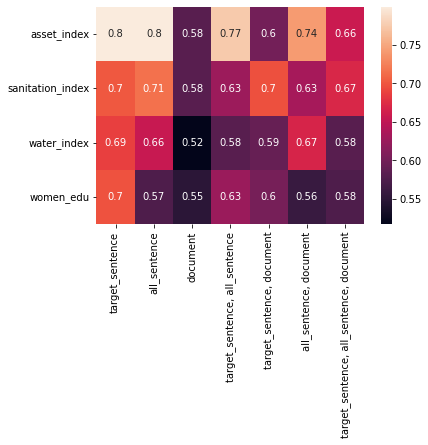

In [11]:
sns.heatmap(scores, annot=True, xticklabels=[", ".join(features) for features in FEATURES], yticklabels=TARGETS)

### Classification: basic feedforward network

In [31]:
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

import numpy as np

In [32]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import nni.retiarii.nn.pytorch

import torch


class _model__fc1__1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layerchoice__mutation_6_1 = torch.nn.modules.activation.LeakyReLU()

    def forward(self, *_inputs):
        layerchoice__mutation_6_1 = self.layerchoice__mutation_6_1(_inputs[0])
        return layerchoice__mutation_6_1



class _model__fc1(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.__0 = torch.nn.modules.linear.Linear(in_features=input_dim, out_features=64)
        self.__1 = _model__fc1__1()

    def forward(self, input__1):
        __0 = self.__0(input__1)
        __1 = self.__1(__0)
        return __1



class _model__fc2__1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layerchoice__mutation_7_0 = torch.nn.modules.activation.ReLU()

    def forward(self, *_inputs):
        layerchoice__mutation_7_0 = self.layerchoice__mutation_7_0(_inputs[0])
        return layerchoice__mutation_7_0



class _model__fc2(nn.Module):
    def __init__(self):
        super().__init__()
        self.__0 = torch.nn.modules.linear.Linear(in_features=64, out_features=128)
        self.__1 = _model__fc2__1()

    def forward(self, input__1):
        __0 = self.__0(input__1)
        __1 = self.__1(__0)
        return __1



class _model__fc3__1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layerchoice__mutation_8_1 = torch.nn.modules.activation.LeakyReLU()

    def forward(self, *_inputs):
        layerchoice__mutation_8_1 = self.layerchoice__mutation_8_1(_inputs[0])
        return layerchoice__mutation_8_1



class _model__fc3(nn.Module):
    def __init__(self):
        super().__init__()
        self.__0 = torch.nn.modules.linear.Linear(in_features=128, out_features=256)
        self.__1 = _model__fc3__1()

    def forward(self, input__1):
        __0 = self.__0(input__1)
        __1 = self.__1(__0)
        return __1



class _model__fc4__1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layerchoice__mutation_9_2 = torch.nn.modules.activation.Sigmoid()

    def forward(self, *_inputs):
        layerchoice__mutation_9_2 = self.layerchoice__mutation_9_2(_inputs[0])
        return layerchoice__mutation_9_2



class _model__fc4(nn.Module):
    def __init__(self):
        super().__init__()
        self.__0 = torch.nn.modules.linear.Linear(in_features=256, out_features=32)
        self.__1 = _model__fc4__1()

    def forward(self, input__1):
        __0 = self.__0(input__1)
        __1 = self.__1(__0)
        return __1



class _model__final_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.__0 = torch.nn.modules.linear.Linear(in_features=32, out_features=2)

    def forward(self, input__1):
        __0 = self.__0(input__1)
        return __0



class Net(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.__fc1 = _model__fc1(input_dim)
        self.__fc2 = _model__fc2()
        self.__fc3 = _model__fc3()
        self.__fc4 = _model__fc4()
        self.__final_layer = _model__final_layer()

    def forward(self, x__1):
        __Constant1 = 2
        __Constant2 = 3
        __Constant3 = 4
        __Attr7 = 4
        __Attr13 = 4
        __Attr19 = 4
        __fc1 = self.__fc1(x__1)
        __aten__ge8 = (__Attr7 >= __Constant1)
        __aten__ge14 = (__Attr13 >= __Constant2)
        __aten__ge20 = (__Attr19 >= __Constant3)
        __fc2 = self.__fc2(__fc1)
        __noop_identity12 = __fc2
        __fc3 = self.__fc3(__noop_identity12)
        __noop_identity18 = __fc3
        __fc4 = self.__fc4(__noop_identity18)
        __noop_identity24 = __fc4
        __final_layer = self.__final_layer(__noop_identity24)
        return __final_layer


In [38]:
def get_data_loader(features, target, rebalance=False):
    ds = SustainBenchTextDataset(
                data_dir="../data/", 
                features=features, 
                target=target,
                model_type='classification',
                classification_threshold=CLASSIFICATION_THRESHOLD_DICT[target],
                rebalance=rebalance
            )

    X_train, y_train = ds.get_data('train')
    X_test, y_test = ds.get_data('test')
    
    print(f'train data shape: {X_train.shape}, test data shape: {X_test.shape}')
    print(f'{sum(y_train)} ({np.round(sum(y_train)/X_train.shape[0] * 100, 2)}%) positive examples in train data, {sum(y_test)} ({np.round(sum(y_test)/X_test.shape[0] * 100, 2)}%) positive examples in test data\n')

    X_train = torch.Tensor(X_train)
    y_train = torch.from_numpy(y_train)
    X_test = torch.Tensor(X_test)
    y_test = torch.from_numpy(y_test)
    
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset)

    
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset)
    
    return train_loader, test_loader

In [39]:
def train(train_loader, net, learning_rate, logging=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        for i, (embeddings, labels) in enumerate(train_loader):
            embeddings = Variable(embeddings)
            labels = Variable(labels)

            optimizer.zero_grad()                  
            outputs = net(embeddings)                   
            loss = criterion(outputs, labels)        
            loss.backward()                            
            optimizer.step() 

            if logging and (i+1) % 100 == 0: 
                print(f'epoch: {epoch+1}/{num_epochs}, step: {int((i+1) / 100)}/{len(train_dataset)//batch_size}, loss: {loss.data}')

    return net

In [40]:
def evaluate(test_loader, net, time_taken):
    y_true = []
    y_pred = []
    for i, (embeddings, labels) in enumerate(test_loader):
        embeddings = Variable(embeddings)
        outputs = net(embeddings)
        _, predicted = torch.max(outputs.data, 1)
        y_true.append(labels.item())
        y_pred.append(predicted.item())

    score = roc_auc_score(y_true, y_pred)
    print(f'basic neural network classifier fit time: {round(time_taken, 3)}s, roc auc: {round(score, 3)}')
    print(classification_report(y_true, y_pred))
    return score

In [41]:
num_classes = 2
num_epochs = 5
batch_size = 100
learning_rate = 0.001

In [42]:
FEATURE_INPUT_SIZE_DICT = {'target_sentence': 384, 'all_sentence': 384, 'document': 300}
scores = np.zeros((len(TARGETS), len(FEATURES)))
for i, target in enumerate(TARGETS):
    for j, features in enumerate(FEATURES):
        print(target, features)
        input_size = sum([FEATURE_INPUT_SIZE_DICT[feature] for feature in features])
        hidden_size = int(input_size / 2)

        train_loader, test_loader = get_data_loader(features, target, rebalance=True)
        net = Net(input_size)
        start = time.time()
        net = train(train_loader, net, learning_rate)
        end = time.time()
        scores[i,j] = evaluate(test_loader, net, end - start)
        print()

asset_index ['target_sentence']
train data shape: (2151, 384), test data shape: (390, 384)
654 (30.4%) positive examples in train data, 122 (31.28%) positive examples in test data

basic neural network classifier fit time: 14.841s, roc auc: 0.611
              precision    recall  f1-score   support

           0       0.96      0.25      0.39       268
           1       0.37      0.98      0.54       122

    accuracy                           0.47       390
   macro avg       0.66      0.61      0.46       390
weighted avg       0.77      0.47      0.44       390


asset_index ['all_sentence']
The PCA model explains 45.848% of the variance in the embedding data
train data shape: (5954, 384), test data shape: (1025, 384)
1830 (30.74%) positive examples in train data, 422 (41.17%) positive examples in test data

basic neural network classifier fit time: 45.744s, roc auc: 0.506
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       603


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1077
           1       0.38      1.00      0.55       665

    accuracy                           0.38      1742
   macro avg       0.19      0.50      0.28      1742
weighted avg       0.15      0.38      0.21      1742


asset_index ['target_sentence', 'all_sentence']
The PCA model explains 45.846% of the variance in the embedding data
train data shape: (2150, 768), test data shape: (390, 768)
654 (30.42%) positive examples in train data, 122 (31.28%) positive examples in test data

basic neural network classifier fit time: 15.25s, roc auc: 0.647
              precision    recall  f1-score   support

           0       0.93      0.35      0.51       268
           1       0.40      0.94      0.56       122

    accuracy                           0.54       390
   macro avg       0.66      0.65      0.53       390
weighted avg       0.76      0.54      0.53       390


asset_index 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       268
           1       0.31      1.00      0.48       122

    accuracy                           0.31       390
   macro avg       0.16      0.50      0.24       390
weighted avg       0.10      0.31      0.15       390


asset_index ['all_sentence', 'document']
The PCA model explains 45.847% of the variance in the embedding data
train data shape: (6091, 684), test data shape: (1025, 684)
1830 (30.04%) positive examples in train data, 422 (41.17%) positive examples in test data

basic neural network classifier fit time: 53.71s, roc auc: 0.5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       603
           1       0.41      1.00      0.58       422

    accuracy                           0.41      1025
   macro avg       0.21      0.50      0.29      1025
weighted avg       0.17      0.41      0.24      1025


asset_index ['target_sentence', 'all_sentence', 'document']
The PCA model explains 45.847% of the variance in the embedding data
train data shape: (2178, 1068), test data shape: (390, 1068)
654 (30.03%) positive examples in train data, 122 (31.28%) positive examples in test data

basic neural network classifier fit time: 24.23s, roc auc: 0.5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       268
           1       0.31      1.00      0.48       122

    accuracy                           0.31       390
   macro avg       0.16      0.50      0.24       390
weighted avg       0.10      0.31      0.15       390


sanitation_index ['target_sentence']
No need to resample, classes are balanced within our tolerated class ratio of 0.3
train data shape: (2660, 384), test data shape: (579, 384)
832 (31.28%) positive examples in train data, 286 (49.4%) positive examples in test data

basic neural network classifier fit time: 18.69s, roc auc: 0.686
              precision    recall  f1-score   support

           0       0.78      0.52      0.63       293
           1       0.63      0.85      0.73       286

    accuracy                           0.68       579
   macro avg       0.71      0.69      0.68       579
weighted avg       0.71      0.68      0.68       579


sanitation_

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1131
           1       0.41      1.00      0.58       792

    accuracy                           0.41      1923
   macro avg       0.21      0.50      0.29      1923
weighted avg       0.17      0.41      0.24      1923


sanitation_index ['target_sentence', 'all_sentence']
The PCA model explains 45.844% of the variance in the embedding data
No need to resample, classes are balanced within our tolerated class ratio of 0.3
train data shape: (2660, 768), test data shape: (579, 768)
832 (31.28%) positive examples in train data, 286 (49.4%) positive examples in test data

basic neural network classifier fit time: 24.498s, roc auc: 0.564
              precision    recall  f1-score   support

           0       0.59      0.45      0.51       293
           1       0.55      0.68      0.61       286

    accuracy                           0.56       579
   macro avg       0.57      0.56  

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       293
           1       0.49      1.00      0.66       286

    accuracy                           0.49       579
   macro avg       0.25      0.50      0.33       579
weighted avg       0.24      0.49      0.33       579


sanitation_index ['all_sentence', 'document']
The PCA model explains 45.845% of the variance in the embedding data
No need to resample, classes are balanced within our tolerated class ratio of 0.3
train data shape: (5823, 684), test data shape: (1140, 684)
1767 (30.35%) positive examples in train data, 508 (44.56%) positive examples in test data

basic neural network classifier fit time: 57.365s, roc auc: 0.5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.55      1.00      0.71       632
           1       0.00      0.00      0.00       508

    accuracy                           0.55      1140
   macro avg       0.28      0.50      0.36      1140
weighted avg       0.31      0.55      0.40      1140


sanitation_index ['target_sentence', 'all_sentence', 'document']
The PCA model explains 45.848% of the variance in the embedding data
No need to resample, classes are balanced within our tolerated class ratio of 0.3
train data shape: (2660, 1068), test data shape: (579, 1068)
832 (31.28%) positive examples in train data, 286 (49.4%) positive examples in test data

basic neural network classifier fit time: 25.599s, roc auc: 0.5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       293
           1       0.49      1.00      0.66       286

    accuracy                           0.49       579
   macro avg       0.25      0.50      0.33       579
weighted avg       0.24      0.49      0.33       579


water_index ['target_sentence']
train data shape: (4113, 384), test data shape: (614, 384)
1234 (30.0%) positive examples in train data, 163 (26.55%) positive examples in test data

basic neural network classifier fit time: 35.117s, roc auc: 0.5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       451
           1       0.27      1.00      0.42       163

    accuracy                           0.27       614
   macro avg       0.13      0.50      0.21       614
weighted avg       0.07      0.27      0.11       614


water_index ['all_sentence']
The PCA model explains 45.844% of the variance in the embedding data
train data shape: (7795, 384), test data shape: (1025, 384)
2339 (30.01%) positive examples in train data, 256 (24.98%) positive examples in test data

basic neural network classifier fit time: 57.801s, roc auc: 0.5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       769
           1       0.25      1.00      0.40       256

    accuracy                           0.25      1025
   macro avg       0.12      0.50      0.20      1025
weighted avg       0.06      0.25      0.10      1025


water_index ['document']
train data shape: (12405, 300), test data shape: (1742, 300)
3722 (30.0%) positive examples in train data, 392 (22.5%) positive examples in test data

basic neural network classifier fit time: 109.576s, roc auc: 0.5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1350
           1       0.23      1.00      0.37       392

    accuracy                           0.23      1742
   macro avg       0.11      0.50      0.18      1742
weighted avg       0.05      0.23      0.08      1742


water_index ['target_sentence', 'all_sentence']
The PCA model explains 45.844% of the variance in the embedding data
train data shape: (4110, 768), test data shape: (614, 768)
1234 (30.02%) positive examples in train data, 163 (26.55%) positive examples in test data

basic neural network classifier fit time: 34.374s, roc auc: 0.5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       451
           1       0.27      1.00      0.42       163

    accuracy                           0.27       614
   macro avg       0.13      0.50      0.21       614
weighted avg       0.07      0.27      0.11       614


water_index ['target_sentence', 'document']
train data shape: (4115, 684), test data shape: (614, 684)
1234 (29.99%) positive examples in train data, 163 (26.55%) positive examples in test data

basic neural network classifier fit time: 35.37s, roc auc: 0.5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       451
           1       0.27      1.00      0.42       163

    accuracy                           0.27       614
   macro avg       0.13      0.50      0.21       614
weighted avg       0.07      0.27      0.11       614


water_index ['all_sentence', 'document']
The PCA model explains 45.845% of the variance in the embedding data
train data shape: (7797, 684), test data shape: (1025, 684)
2339 (30.0%) positive examples in train data, 256 (24.98%) positive examples in test data

basic neural network classifier fit time: 72.947s, roc auc: 0.5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       769
           1       0.25      1.00      0.40       256

    accuracy                           0.25      1025
   macro avg       0.12      0.50      0.20      1025
weighted avg       0.06      0.25      0.10      1025


water_index ['target_sentence', 'all_sentence', 'document']
The PCA model explains 45.847% of the variance in the embedding data
train data shape: (4115, 1068), test data shape: (614, 1068)
1234 (29.99%) positive examples in train data, 163 (26.55%) positive examples in test data

basic neural network classifier fit time: 38.336s, roc auc: 0.5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       451
           1       0.27      1.00      0.42       163

    accuracy                           0.27       614
   macro avg       0.13      0.50      0.21       614
weighted avg       0.07      0.27      0.11       614


women_edu ['target_sentence']
train data shape: (5190, 384), test data shape: (1162, 384)
1564 (30.13%) positive examples in train data, 523 (45.01%) positive examples in test data

basic neural network classifier fit time: 42.62s, roc auc: 0.5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       639
           1       0.45      1.00      0.62       523

    accuracy                           0.45      1162
   macro avg       0.23      0.50      0.31      1162
weighted avg       0.20      0.45      0.28      1162


women_edu ['all_sentence']
The PCA model explains 45.848% of the variance in the embedding data
train data shape: (7950, 384), test data shape: (1857, 384)
2421 (30.45%) positive examples in train data, 736 (39.63%) positive examples in test data

basic neural network classifier fit time: 60.532s, roc auc: 0.5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1121
           1       0.40      1.00      0.57       736

    accuracy                           0.40      1857
   macro avg       0.20      0.50      0.28      1857
weighted avg       0.16      0.40      0.22      1857


women_edu ['document']
train data shape: (12636, 300), test data shape: (3015, 300)
3804 (30.1%) positive examples in train data, 1038 (34.43%) positive examples in test data

basic neural network classifier fit time: 112.69s, roc auc: 0.5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1977
           1       0.34      1.00      0.51      1038

    accuracy                           0.34      3015
   macro avg       0.17      0.50      0.26      3015
weighted avg       0.12      0.34      0.18      3015


women_edu ['target_sentence', 'all_sentence']
The PCA model explains 45.848% of the variance in the embedding data
train data shape: (5181, 768), test data shape: (1162, 768)
1564 (30.19%) positive examples in train data, 523 (45.01%) positive examples in test data

basic neural network classifier fit time: 38.87s, roc auc: 0.536
              precision    recall  f1-score   support

           0       0.96      0.08      0.14       639
           1       0.47      1.00      0.64       523

    accuracy                           0.49      1162
   macro avg       0.71      0.54      0.39      1162
weighted avg       0.74      0.49      0.36      1162


women_edu ['

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       639
           1       0.45      1.00      0.62       523

    accuracy                           0.45      1162
   macro avg       0.23      0.50      0.31      1162
weighted avg       0.20      0.45      0.28      1162


women_edu ['all_sentence', 'document']
The PCA model explains 45.847% of the variance in the embedding data
train data shape: (8060, 684), test data shape: (1857, 684)
2421 (30.04%) positive examples in train data, 736 (39.63%) positive examples in test data

basic neural network classifier fit time: 77.069s, roc auc: 0.5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1121
           1       0.40      1.00      0.57       736

    accuracy                           0.40      1857
   macro avg       0.20      0.50      0.28      1857
weighted avg       0.16      0.40      0.22      1857


women_edu ['target_sentence', 'all_sentence', 'document']
The PCA model explains 45.848% of the variance in the embedding data
train data shape: (5213, 1068), test data shape: (1162, 1068)
1564 (30.0%) positive examples in train data, 523 (45.01%) positive examples in test data

basic neural network classifier fit time: 50.937s, roc auc: 0.5


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       639
           1       0.45      1.00      0.62       523

    accuracy                           0.45      1162
   macro avg       0.23      0.50      0.31      1162
weighted avg       0.20      0.45      0.28      1162




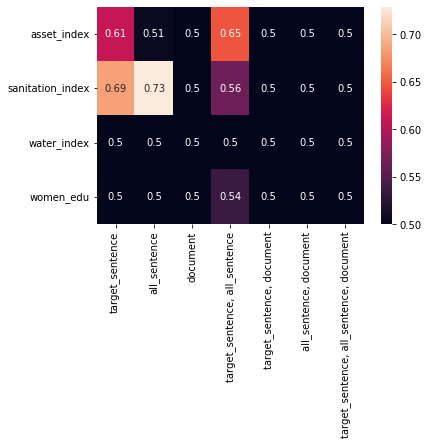

In [43]:
import seaborn as sns
sns.heatmap(scores, annot=True, xticklabels=[", ".join(features) for features in FEATURES], yticklabels=TARGETS)

In [24]:
scores = np.zeros((len(TARGETS), len(FEATURES)))
for i, target in enumerate(TARGETS):
    for j, features in enumerate(FEATURES):
        print(target, features)
        input_size = sum([FEATURE_INPUT_SIZE_DICT[feature] for feature in features])
        hidden_size = int(input_size / 2)

        train_loader, test_loader = get_data_loader(features, target, rebalance=True)
        net = Net(input_size, hidden_size, num_classes)
        start = time.time()
        net = train(train_loader, net, learning_rate)
        end = time.time()
        scores[i,j] = evaluate(test_loader, net, end - start)
        print()

asset_index ['target_sentence']
train data shape: (2155, 384), test data shape: (390, 384)
654 (30.35%) positive examples in train data, 122 (31.28%) positive examples in test data

basic neural network classifier fit time: 7.617s, roc auc: 0.578
              precision    recall  f1-score   support

           0       1.00      0.16      0.27       268
           1       0.35      1.00      0.52       122

    accuracy                           0.42       390
   macro avg       0.68      0.58      0.40       390
weighted avg       0.80      0.42      0.35       390


asset_index ['all_sentence']
The PCA model explains 45.848% of the variance in the embedding data
train data shape: (5959, 384), test data shape: (1025, 384)
1830 (30.71%) positive examples in train data, 422 (41.17%) positive examples in test data

basic neural network classifier fit time: 21.056s, roc auc: 0.612
              precision    recall  f1-score   support

           0       0.95      0.24      0.39       603


basic neural network classifier fit time: 30.997s, roc auc: 0.582
              precision    recall  f1-score   support

           0       0.64      0.55      0.59       632
           1       0.52      0.62      0.57       508

    accuracy                           0.58      1140
   macro avg       0.58      0.58      0.58      1140
weighted avg       0.59      0.58      0.58      1140


sanitation_index ['target_sentence', 'all_sentence', 'document']
The PCA model explains 45.846% of the variance in the embedding data
No need to resample, classes are balanced within our tolerated class ratio of 0.3
train data shape: (2660, 1068), test data shape: (579, 1068)
832 (31.28%) positive examples in train data, 286 (49.4%) positive examples in test data

basic neural network classifier fit time: 26.089s, roc auc: 0.642
              precision    recall  f1-score   support

           0       0.75      0.43      0.54       293
           1       0.59      0.86      0.70       286

    accur

/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-sco

The PCA model explains 45.848% of the variance in the embedding data
train data shape: (7792, 384), test data shape: (1025, 384)
2339 (30.02%) positive examples in train data, 256 (24.98%) positive examples in test data

basic neural network classifier fit time: 27.798s, roc auc: 0.508
              precision    recall  f1-score   support

           0       1.00      0.02      0.03       769
           1       0.25      1.00      0.40       256

    accuracy                           0.26      1025
   macro avg       0.63      0.51      0.22      1025
weighted avg       0.81      0.26      0.13      1025


water_index ['document']
train data shape: (12405, 300), test data shape: (1742, 300)
3722 (30.0%) positive examples in train data, 392 (22.5%) positive examples in test data

basic neural network classifier fit time: 36.006s, roc auc: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1350
           1       0.23      1.00   

/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-sco

The PCA model explains 45.848% of the variance in the embedding data
train data shape: (4110, 768), test data shape: (614, 768)
1234 (30.02%) positive examples in train data, 163 (26.55%) positive examples in test data

basic neural network classifier fit time: 24.087s, roc auc: 0.514
              precision    recall  f1-score   support

           0       1.00      0.03      0.06       451
           1       0.27      1.00      0.43       163

    accuracy                           0.29       614
   macro avg       0.64      0.51      0.24       614
weighted avg       0.81      0.29      0.15       614


water_index ['target_sentence', 'document']
train data shape: (4115, 684), test data shape: (614, 684)
1234 (29.99%) positive examples in train data, 163 (26.55%) positive examples in test data

basic neural network classifier fit time: 21.963s, roc auc: 0.5
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       451
           1      

/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/caravanuden/git-repos/Multimodal-deep-learning-for-poverty-prediction/venvs/sustainbench/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-sco

The PCA model explains 45.847% of the variance in the embedding data
train data shape: (7797, 684), test data shape: (1025, 684)
2339 (30.0%) positive examples in train data, 256 (24.98%) positive examples in test data

basic neural network classifier fit time: 41.518s, roc auc: 0.503
              precision    recall  f1-score   support

           0       1.00      0.01      0.01       769
           1       0.25      1.00      0.40       256

    accuracy                           0.25      1025
   macro avg       0.63      0.50      0.21      1025
weighted avg       0.81      0.25      0.11      1025


water_index ['target_sentence', 'all_sentence', 'document']
The PCA model explains 45.847% of the variance in the embedding data
train data shape: (4115, 1068), test data shape: (614, 1068)
1234 (29.99%) positive examples in train data, 163 (26.55%) positive examples in test data

basic neural network classifier fit time: 38.804s, roc auc: 0.503
              precision    recall  f1-

<AxesSubplot:>

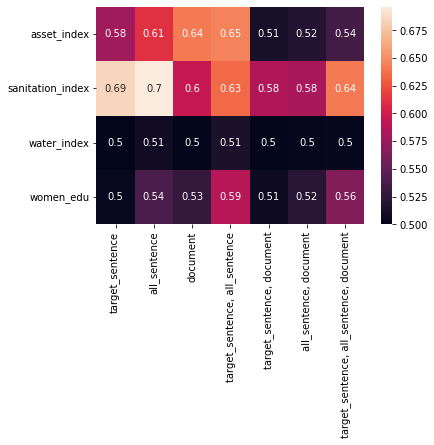

In [25]:
sns.heatmap(scores, annot=True, xticklabels=[", ".join(features) for features in FEATURES], yticklabels=TARGETS)